<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/diff-aug/Evaluate_TransGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Check GPU
!nvidia-smi

Wed Apr 14 13:28:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   51C    P0    26W / 120W |    730MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace
import json
from metrics.torch_is_fid_score import is_fid_from_generator

In [3]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images, set_seed
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [4]:
gdrive = Path('C:\\GANs\\')

In [5]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [6]:
!set PYTHONPATH=%PYTHONPATH%;C:/GitHub/GANs && python ./scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats\cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Inference

In [7]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999
num_epochs = 20

In [8]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
# display_images(dataset.train_loader)

Files already downloaded and verified


In [9]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

In [10]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
# summary(Dis,(3,32,32,))

In [11]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
with open('results.json') as fp:
  results = json.load(fp)

In [ ]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
experiments = ['no_aug', 'flip_lr', 'full_aug']

for exp in experiments:
  ckp_folder = gdrive/exp
  for filename in os.listdir(ckp_folder):
       
      epoch = int(filename[:-4].split('_')[-1])
      if epoch not in results[exp]['epochs']:
      
          Gen, Dis, optG, optD, start_epoch, old_logs = \
              Checkpoint.load_checkpoint(ckp_folder/filename, Gen, Dis, optG, optD)
          assert start_epoch > 0
          
          inception_score, fid = is_fid_from_generator(generator=Gen,
                                                  latent_dims=latent_dims,
                                                  num_imgs=10000,
                                                  batch_sz=64,
                                                  fid_stat_path = stat_path)
          print(fid)
          results[exp]['iss'].append(inception_score)
          results[exp]['fids'].append(fid)
          results[exp]['epochs'].append(epoch)


In [14]:
with open('results.json', 'w') as fp:
  json.dump(results, fp)

# Analysis

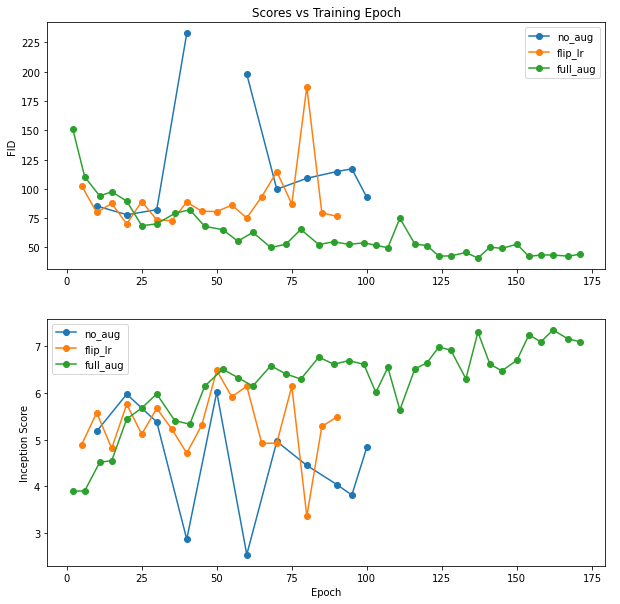

In [31]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for idx, exp in enumerate(results.keys()):
  e = results[exp]['epochs']
  fid = results[exp]['fids']
  inception_score = results[exp]['iss']
  score = [s[0] for s in inception_score]

  axs[0].plot(e,fid,'-o',label=exp)
  axs[1].plot(e,score,'-o', label=exp)

axs[0].set_ylabel('FID')
axs[1].set_ylabel('Inception Score')

plt.title('Scores vs Training Epoch')
plt.xlabel("Epoch")

axs[0].legend()
axs[1].legend()
plt.show()